In [1]:
import os
import random
import copy
import torchvision
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from dataset_class import FaceMaskDataset

# Import dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image number: 1655
Image shape: torch.Size([3, 224, 224])
Label: 0


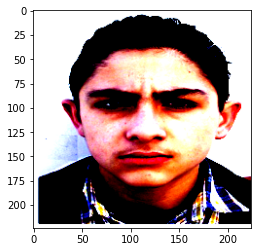

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image number: 886
Image shape: torch.Size([3, 224, 224])
Label: 0


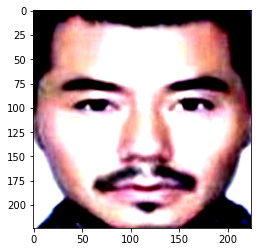

Image number: 2152

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Image shape: torch.Size([3, 224, 224])
Label: 1


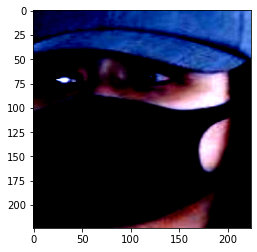

Image number: 2093

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Image shape: torch.Size([3, 224, 224])
Label: 1


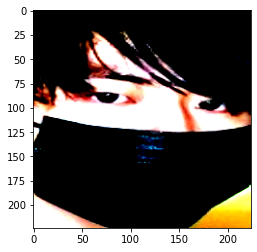

Image number: 3749
Image shape: torch.Size([3, 224, 224])
Label: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


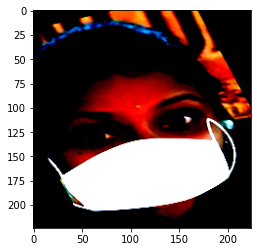

In [2]:
transform_to_tensor = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)), 
                                                      torchvision.transforms.ToTensor(),
                                                      torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
face_mask_dataset = FaceMaskDataset(root_dir='dataset', transform=transform_to_tensor)

for i in random.sample(range(0, len(face_mask_dataset)), 5):
    image, label = face_mask_dataset[i]

    print(f'Image number: {i}')
    print(f'Image shape: {image.shape}')
    print(f'Label: {label}')

    fig =  plt.figure()
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

# Train/test split

In [3]:
dataset_indices = list(range(len(face_mask_dataset)))

random.shuffle(dataset_indices)
train_split_indices = dataset_indices[:int(len(dataset_indices)*0.5)]  
valid_split_indices = dataset_indices[int(len(dataset_indices)*0.5):] 

train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_split_indices)
valid_subset_sampler = torch.utils.data.SubsetRandomSampler(valid_split_indices)
batch_size = 32
num_workers = 8

train_dataloader = torch.utils.data.DataLoader(dataset=face_mask_dataset, batch_size=batch_size, sampler=train_subset_sampler, num_workers=num_workers)
valid_dataloader = torch.utils.data.DataLoader(dataset=face_mask_dataset, batch_size=batch_size, sampler=valid_subset_sampler, num_workers=num_workers)

dataloaders = {'train': train_dataloader, 'val': valid_dataloader}
dataset_sizes = {'train': len(train_subset_sampler), 'val': len(valid_subset_sampler)}

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Define and train model

In [5]:
def plot_accuracy_los(train_accuracy, train_loss, val_accuracy, val_loss, epochs, name=None):
    plt.style.use("ggplot")
    plt.figure()
    
    plt.plot(np.arange(0, epochs), train_loss, label="train_loss")
    plt.plot(np.arange(0, epochs), val_loss, label="val_loss")
    plt.plot(np.arange(0, epochs), train_accuracy, label="train_acc")
    plt.plot(np.arange(0, epochs), val_accuracy, label="val_acc")
    
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    if name != None:
        plt.savefig(name + '.png')

In [6]:
def train_model(model, criterion, optimizer, num_epochs):
    start_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 50)

        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[mode]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(mode == 'train'):
                    outputs = model(inputs)
                    
                    outputs = torch.log_softmax(outputs, -1)
                    
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training mode
                    if mode == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / dataset_sizes[mode]
            epoch_acc = float(running_corrects) / dataset_sizes[mode]
            
            if mode == 'train':
                train_accuracy.append(epoch_acc)
                train_loss.append(epoch_loss)
            else:
                val_accuracy.append(epoch_acc)
                val_loss.append(epoch_loss)

            print(f'{mode} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if mode == 'val' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start_time
    print(f'Training complete in {(time_elapsed // 60):.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_accuracy:4f}')
    
    name = input('Enter image file name:')
    plot_accuracy_los(train_accuracy, train_loss, val_accuracy, val_loss, num_epochs, name)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_name = 'inception_v3' # can be 'resnet50' and 'inception_v3'

if model_name == 'resnet50':
    model = torchvision.models.resnet50(pretrained=True)
elif model_name == 'inception_v3':
    model = torchvision.models.inception_v3(pretrained=True)
    model.aux_logits=False

# do not update pretrained weights
for param in model.parameters():
    param.requires_grad = False
    
finetuned_model = copy.deepcopy(model)

num_ftrs = finetuned_model.fc.in_features
finetuned_model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(num_ftrs, 2))

finetuned_model = finetuned_model.to(device) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, finetuned_model.parameters()))

num_epochs = 100

# change num_epochs to smaller number for faster iteration
best_model = train_model(finetuned_model, criterion, optimizer, num_epochs)  

In [7]:
# torch.save(best_model, 'models/inception_50_50_epochs100_acc0968254.pt')
best_model = torch.load('models/inception_50_50_epochs100_acc0968254.pt')
# print(best_model)

# Visualize model output

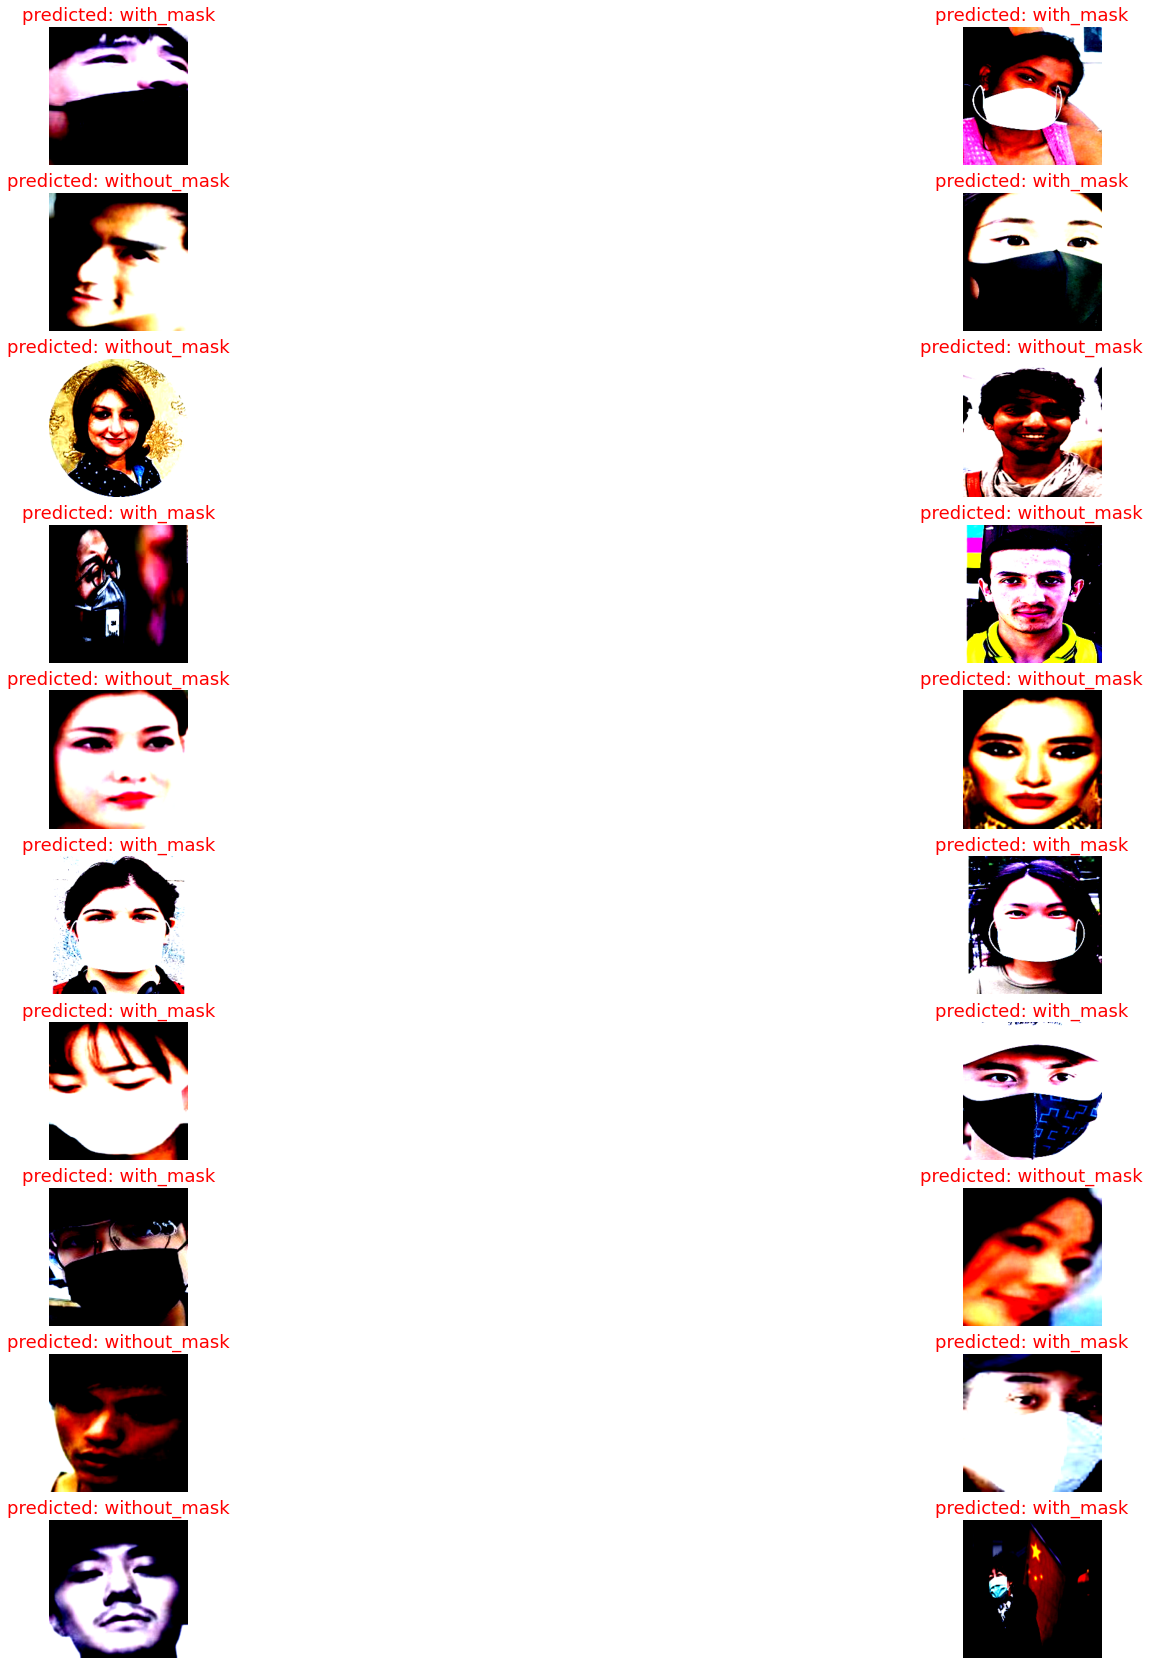

In [8]:
def visualize_model(model, num_images=20):
    model.eval()
    model = model.to(device)
    
    images_so_far = 0
    fig = plt.figure(figsize=(30, 30))
    
    params = {'text.color': 'red', 'font.size': 15}
    plt.rcParams.update(params)

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            
            outputs = torch.softmax(outputs, -1)
            
            tmp, preds = torch.max(outputs, 1)

            for i in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(face_mask_dataset.class_names[preds[i]]))
                
                img = inputs.cpu().data[i].numpy().transpose((1, 2, 0))
                img = np.clip(img, 0, 1)  

                plt.imshow(img)

                if images_so_far == num_images:
                    return
            
            plt.show()
            
            
visualize_model(best_model)

# Evaluate model

3it [00:00,  2.76it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


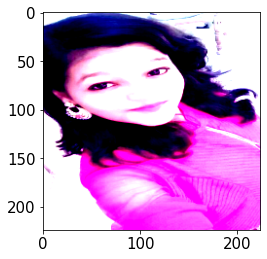

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


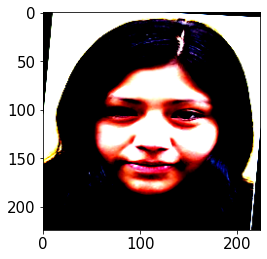

6it [00:01,  3.31it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


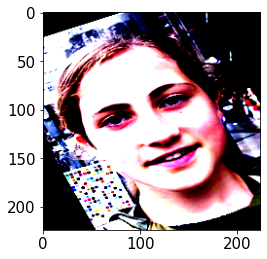

7it [00:02,  3.04it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


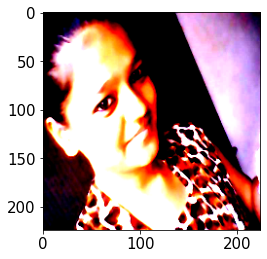

8it [00:02,  2.89it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


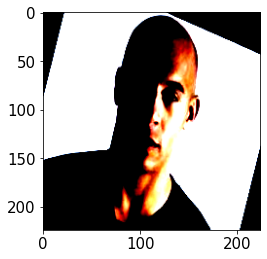

9it [00:03,  2.83it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


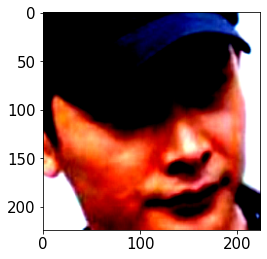

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


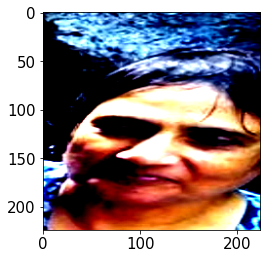

10it [00:03,  2.35it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


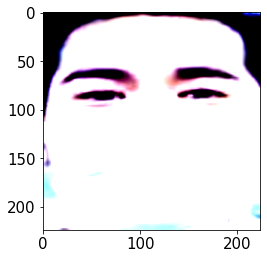

11it [00:04,  2.44it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


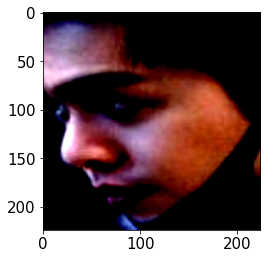

13it [00:04,  2.90it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


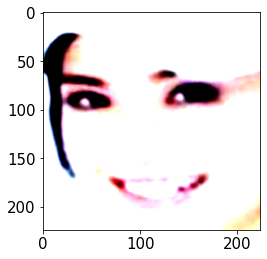

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


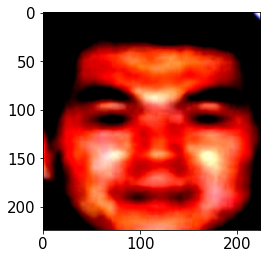

15it [00:05,  2.89it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


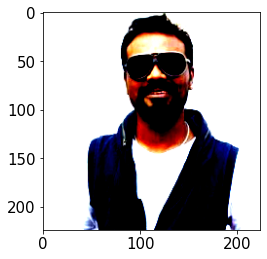

16it [00:05,  2.84it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


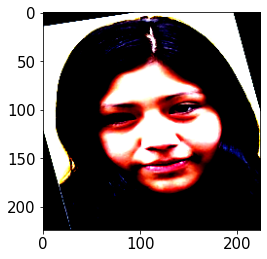

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


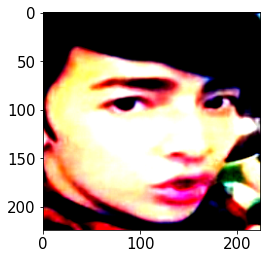

17it [00:06,  2.28it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


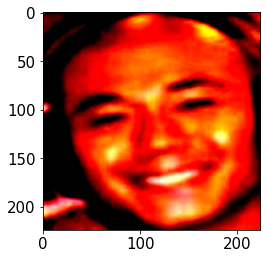

18it [00:06,  2.38it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


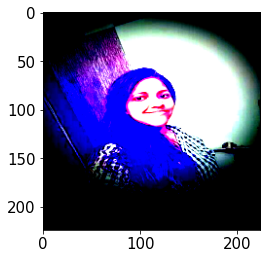

19it [00:07,  2.45it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


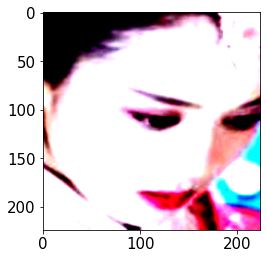

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


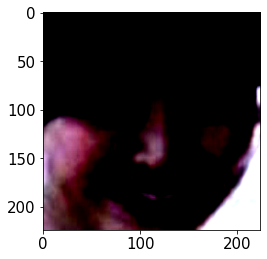

20it [00:07,  2.23it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


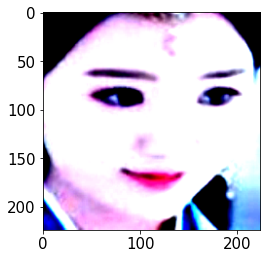

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


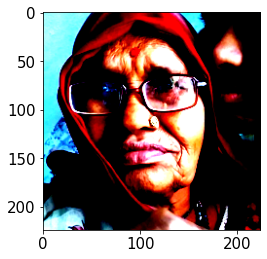

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


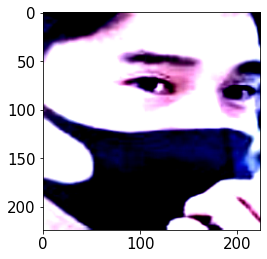

25it [00:09,  3.66it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


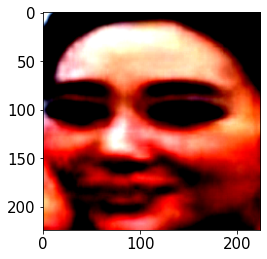

27it [00:09,  3.67it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


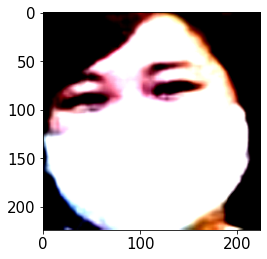

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


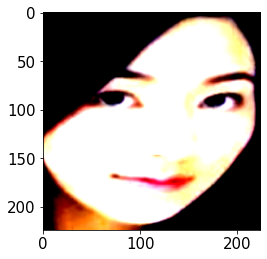

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


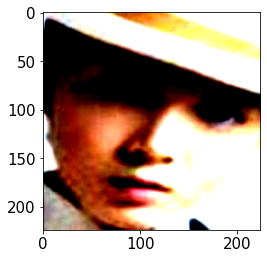

28it [00:10,  2.40it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


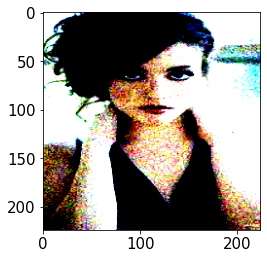

29it [00:10,  2.46it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


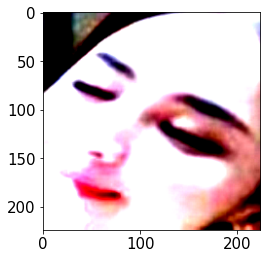

31it [00:11,  3.01it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


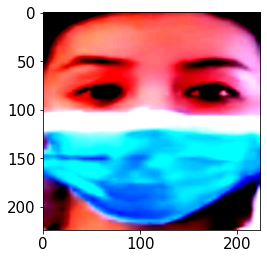

32it [00:11,  2.87it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


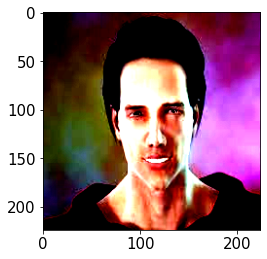

33it [00:12,  2.62it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


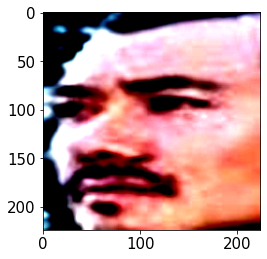

34it [00:12,  2.59it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


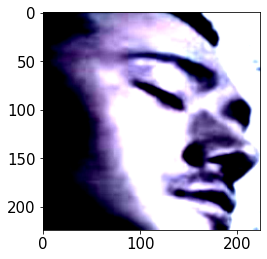

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


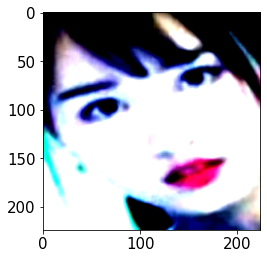

35it [00:13,  2.26it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


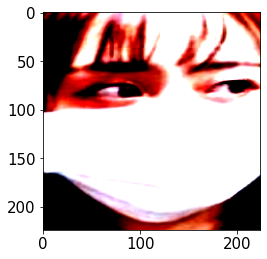

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


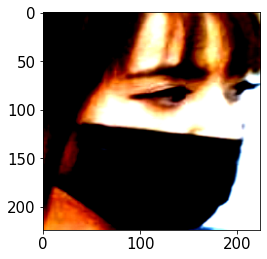

36it [00:13,  2.09it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


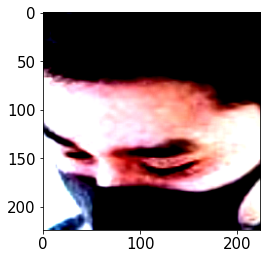

39it [00:14,  3.17it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


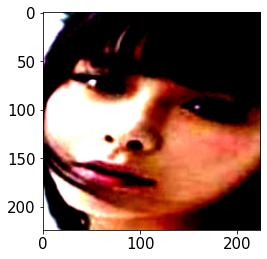

40it [00:14,  3.01it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


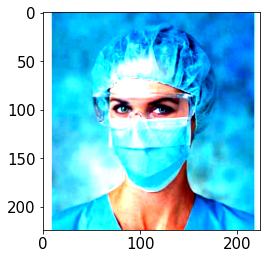

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


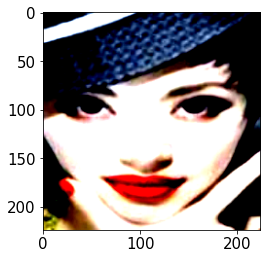

44it [00:16,  3.79it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


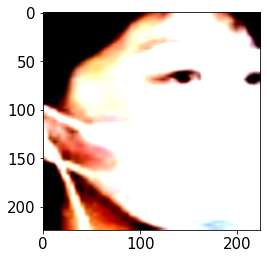

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


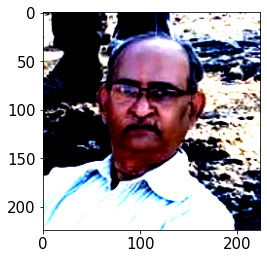

45it [00:16,  2.77it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


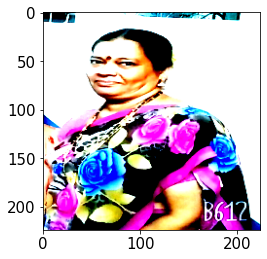

46it [00:17,  2.74it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


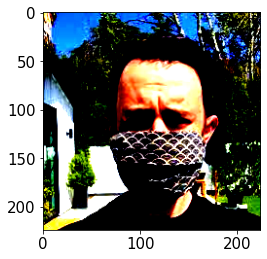

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


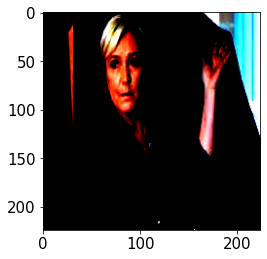

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


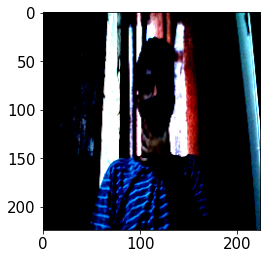

48it [00:18,  2.55it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


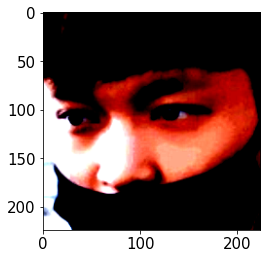

49it [00:18,  2.46it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


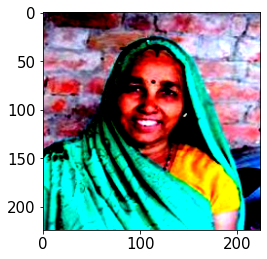

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


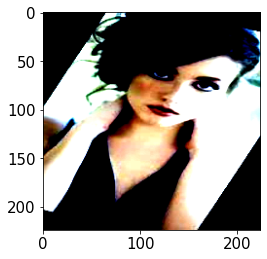

50it [00:19,  2.16it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


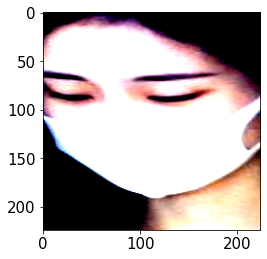

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


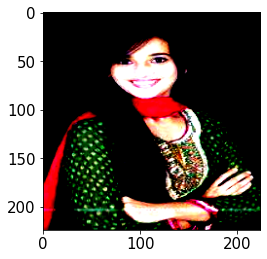

51it [00:19,  2.00it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


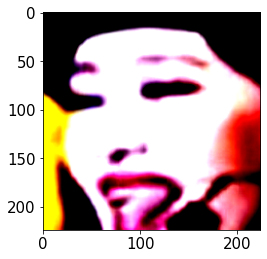

52it [00:20,  2.17it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


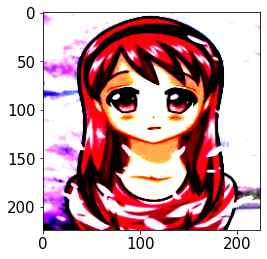

53it [00:20,  2.24it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


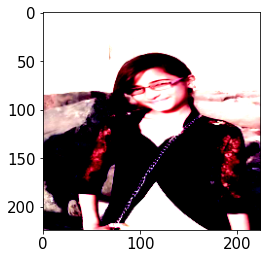

55it [00:20,  2.84it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


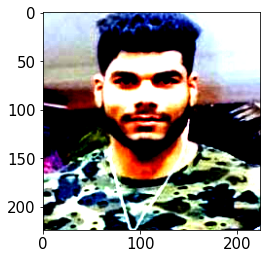

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


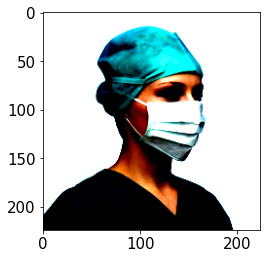

57it [00:21,  2.86it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


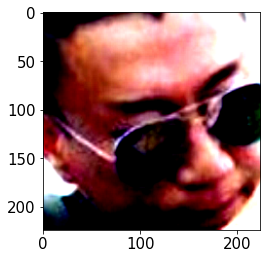

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


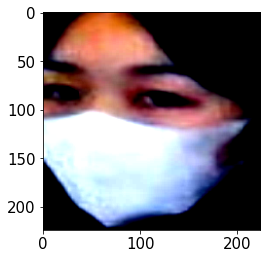

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


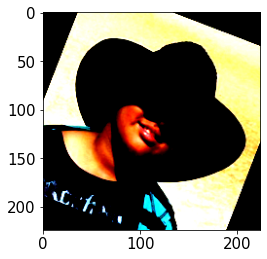

59it [00:22,  2.55it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


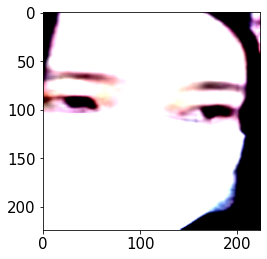

61it [00:23,  3.08it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


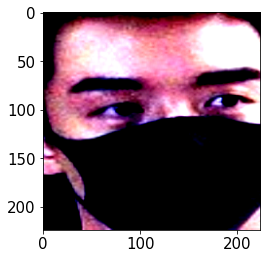

62it [00:23,  2.95it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


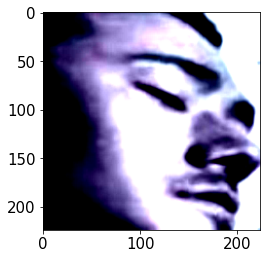

63it [00:24,  2.85it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


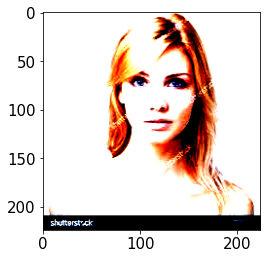

65it [00:24,  3.09it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


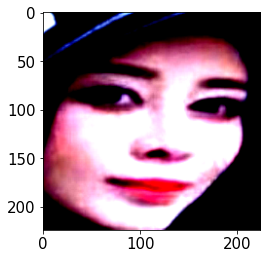

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


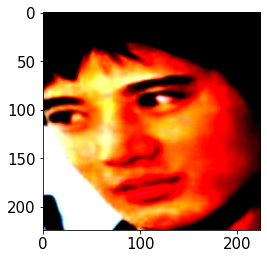

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


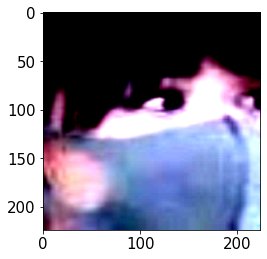

67it [00:25,  2.65it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


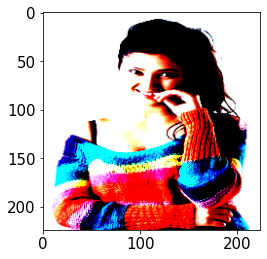

69it [00:26,  3.11it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


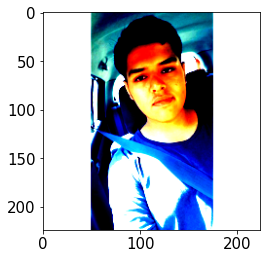

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


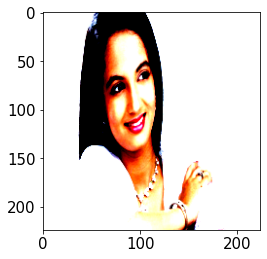

70it [00:26,  2.55it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


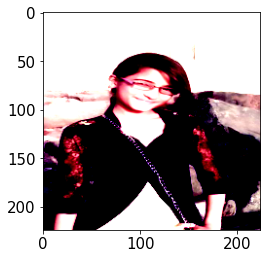

71it [00:27,  2.60it/s]


Evaluate model on training set


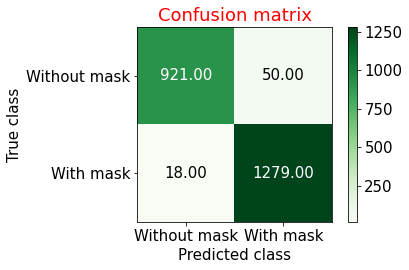

Accuracy: 0.9700176366843033
Precision(with mask): 0.9623777276147479
Recall(with mask): 0.9861218195836546
F1: 0.9741051028179741


In [24]:
from evaluation import evaluate_model

best_model.cuda()
best_model.eval()

all_val_labels = torch.empty(0).to(device)
all_val_pred = torch.empty(0).to(device)
all_probabilities = torch.empty(0).to(device)

plt.figure()

with torch.no_grad():
    for i, (inputs, labels) in tqdm(enumerate(dataloaders['val'])):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = best_model(inputs)

        outputs = torch.log_softmax(outputs, -1)

        if i == 0: 
            all_probabilities = outputs
        else:
            all_probabilities = torch.cat((all_probabilities, outputs), 0)

        _, preds = torch.max(outputs, 1)
        
        differs = preds != labels
        for i in range(len(differs)):
            if differs[i]:
                plt.imshow(inputs[i].cpu().permute(1, 2, 0))
                plt.savefig('found_errors/val/error'+str(i)+'.png')
                plt.show()
        
        all_val_labels = torch.cat((all_val_labels.long(), labels.long()))
        all_val_pred = torch.cat((all_val_pred.long(), preds.long()))

evaluate_model(all_val_labels.cpu(), all_val_pred.cpu(), all_probabilities[1], 'Evaluate model on training set')

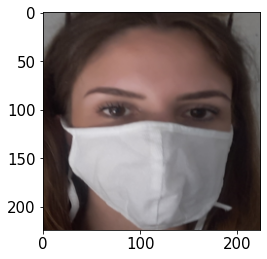

Predicted class: with_mask


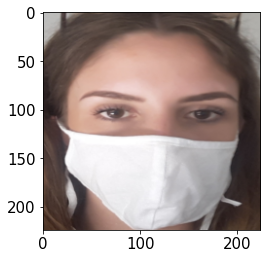

Predicted class: with_mask


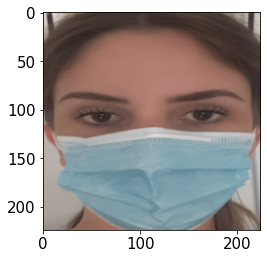

Predicted class: with_mask


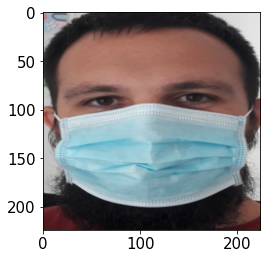

Predicted class: with_mask


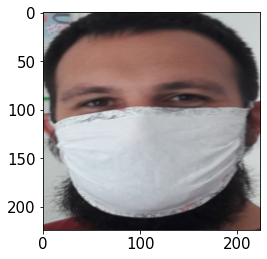

Predicted class: with_mask


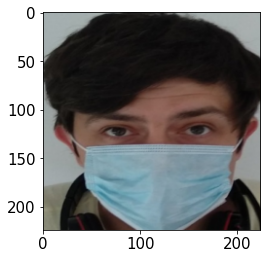

Predicted class: with_mask


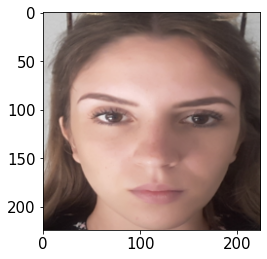

Predicted class: with_mask


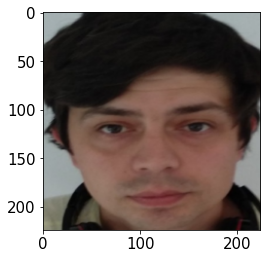

Predicted class: without_mask


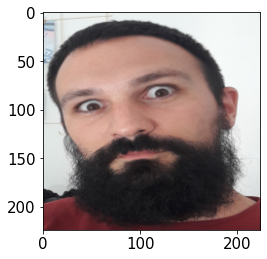

Predicted class: without_mask


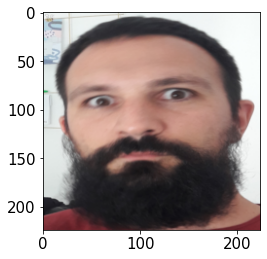

Predicted class: with_mask


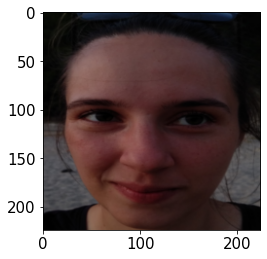

Predicted class: with_mask


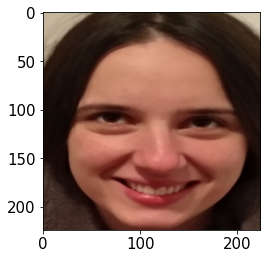

Predicted class: without_mask


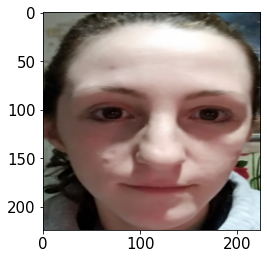

Predicted class: without_mask


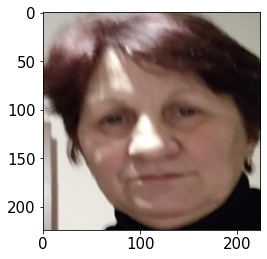

Predicted class: with_mask


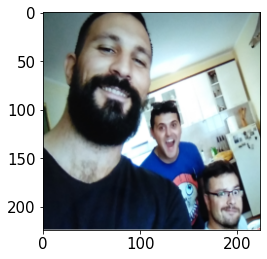

Predicted class: without_mask


In [20]:
from PIL import Image
from imutils import paths


best_model.cpu()
paths = list(paths.list_images('test_dataset'))
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)), 
                                            torchvision.transforms.ToTensor()])

fig =  plt.figure()

for path in paths:
    image = Image.open(path).convert("RGB")
    image = transform(image)
    img = image.unsqueeze(0)

    output = best_model(img)
    _, predicted = torch.max(output, 1)
    
    plt.imshow(image.permute(1, 2, 0))
    plt.show()
    
    print(f'Predicted class: {face_mask_dataset.class_names[predicted[0]]}')